In [1]:
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tifffile
#%gui qt5
#import napari
import scipy.ndimage as ndimage

from read_roi import read_roi_file
from read_roi import read_roi_zip
import skimage
import cv2
from PIL import Image
import glob
import skimage.transform as transform
import os

from torch import nn, optim
import torch.nn.functional as F
import torch
from torchvision import datasets, transforms

In [2]:
#data = '/n/core/micro/cry/rg2128/smc/DeepLearn3D/'
data = '/n/core/micro/asa/fgm/smc/20190919_Screen/DeepLearn/Training/Test/'

In [3]:
window_size = [8, 128, 128]

In [5]:
rescale = [1.0, 1.0, 1.0]

In [6]:
#####inp is assumed to be a single channel 3D, wsize reflects this
def make_windows(inp, wsize):
    new_dims = 2*np.ceil(np.array(inp.shape)/np.array(wsize)).astype(int)
    windowed = np.zeros([np.prod(new_dims),
                wsize[0], wsize[1], wsize[2]])
    expanded = (new_dims/2*np.array(wsize)).astype(int)
    padding = expanded - np.array(inp.shape) + np.array(wsize)
    B = np.pad(inp, ((0,padding[0]), (0,padding[1]), (0,padding[2])), constant_values=(0,0))
    idx = 0
    hz = int(wsize[0]/2)
    hx = int(wsize[1]/2)
    hy = int(wsize[2]/2)
    for z in range(0,new_dims[0]):
        for x in range(0,new_dims[1]):
            for y in range(0,new_dims[2]):
                windowed[idx] = B[(z*hz):(z*hz+2*hz), (x*hx):(x*hx+2*hx), (y*hy):(y*hy+2*hy)]
                idx = idx+1
    return windowed

In [7]:
def de_window(windowed, wsize, original_dims):
    
    original = windowed.copy()
    border = [2, 10, 10]
    original[:,0:border[0],:,:] = 0
    original[:,-border[0]:,:,:] = 0
    
    original[:,:,0:border[1],:] = 0
    original[:,:,-border[1]:,:] = 0
    
    original[:,:,:,0:border[2]] = 0
    original[:,:,:,-border[2]:] = 0
    
    new_dims = 2*np.ceil(np.array(original_dims)/np.array(wsize)).astype(int)
    expanded = (new_dims/2*np.array(wsize)).astype(int)
    padding = expanded - np.array(original_dims) + np.array(wsize)
    dewinned = np.zeros([original_dims[0]+padding[0], original_dims[1]+padding[1], original_dims[2]+padding[2]])
    idx = 0
    hz = int(wsize[0]/2)
    hx = int(wsize[1]/2)
    hy = int(wsize[2]/2)
    for z in range(0,new_dims[0]):
        for x in range(0,new_dims[1]):
            for y in range(0,new_dims[2]):
                current = dewinned[(z*hz):(z*hz+2*hz), (x*hx):(x*hx+2*hx), (y*hy):(y*hy+2*hy)]
                maxxed = np.maximum(current, original[idx])
                dewinned[(z*hz):(z*hz+2*hz), (x*hx):(x*hx+2*hx), (y*hy):(y*hy+2*hy)] = maxxed
                idx = idx+1
    dewinned = dewinned[0:original_dims[0], 0:original_dims[1], 0:original_dims[2]]
    

    return dewinned


# Load training data

In [8]:
def make_labeled_image(fname, img_size):
    Labeled = np.zeros(img_size)
    if os.path.isfile(fname):
        rois = read_roi_zip(fname)

        for i, roi in rois.items():
            x = int(roi['x'][0])
            y = int(roi['y'][0])
            position = roi['position']
            # roi.position can be int or dict
            if isinstance(position, int):
                z = position - 1  # One indexed
            else:
                z = position['slice'] - 1  # One indexed
            Labeled[z,y,x] = 255
        Labeled = transform.rescale(Labeled, rescale)
        Labeled = ndimage.gaussian_filter(Labeled, [0.75,1.5,1.5])   
    else:
        Labeled = transform.rescale(Labeled, rescale)
    return Labeled

In [9]:
def get_training_file(inp, channel=-1):
    data = tifffile.imread(inp)
    if len(data.shape)>3:
        data = data[:,channel,:,:]
    labels = make_labeled_image(inp[0:-4]+'.zip', data.shape)
    data = transform.rescale(data, rescale)
    return data, labels

In [10]:
raws = np.array(None)
labs = np.array(None)
for f in glob.glob(data + 'Training/*.tif'):
    print(f)
    if len(raws.shape)==0:
        raws, labs = get_training_file(f[0:-4]+'.tif', 1)
        raws = make_windows(raws, window_size)
        labs = make_windows(labs, window_size)
    else:
        raw, lab = get_training_file(f[0:-4]+'.tif', 1)
        raw = make_windows(raw, window_size)
        lab = make_windows(lab, window_size)
        
        raws = np.concatenate([raws, raw])
        labs = np.concatenate([labs, lab])

have_something = np.amax(labs, axis=(1,2,3))>0    
have_nothing = np.amax(labs, axis=(1,2,3))==0    

bad_idx = np.where(have_nothing)[0]
good_idx = np.where(have_something)[0]

fraction_to_be_bad = 0.3
num_bad = np.floor(good_idx.shape[0]/(1.0-fraction_to_be_bad)-good_idx.shape[0]).astype(int)

worth_keeping = np.concatenate([good_idx, np.random.choice(bad_idx, size=num_bad, replace=False)])

raws = raws[worth_keeping]
labs = labs[worth_keeping]

/n/core/micro/asa/fgm/smc/20190919_Screen/DeepLearn/Training/Test/Training/A.tif
/n/core/micro/asa/fgm/smc/20190919_Screen/DeepLearn/Training/Test/Training/D.tif
/n/core/micro/asa/fgm/smc/20190919_Screen/DeepLearn/Training/Test/Training/E.tif
/n/core/micro/asa/fgm/smc/20190919_Screen/DeepLearn/Training/Test/Training/B.tif
/n/core/micro/asa/fgm/smc/20190919_Screen/DeepLearn/Training/Test/Training/G.tif
/n/core/micro/asa/fgm/smc/20190919_Screen/DeepLearn/Training/Test/Training/F.tif
/n/core/micro/asa/fgm/smc/20190919_Screen/DeepLearn/Training/Test/Training/C.tif


In [11]:
tifffile.imsave(data+'init_raws.tif', raws.astype(np.single), imagej=True)
tifffile.imsave(data+'init_labs.tif', labs.astype(np.single), imagej=True)

# Augment training data

In [12]:
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

In [13]:
def translate_image(image, xshift, yshift):
    translation_matrix = np.float32([ [1,0,xshift], [0,1,yshift] ])
    img_translation = cv2.warpAffine(image, translation_matrix, image.shape[1::-1])
    return img_translation

In [14]:
def rotate_translate_split(inp, inp2):
    concated = np.concatenate([inp,inp2])
    angle = np.random.randint(0,180)
    xshift = np.random.randint(-20,20)
    yshift = np.random.randint(-20,20)
    full = np.reshape(concated, [concated.shape[0]*concated.shape[1], concated.shape[2], concated.shape[3]])
    new_fulls = np.array([np.array(translate_image(rotate_image(f, angle), 
                                                  xshift, yshift)) for f in full])
    new_fulls = np.reshape(new_fulls, concated.shape)
    return new_fulls[0:int(new_fulls.shape[0]/2),:], new_fulls[-int(new_fulls.shape[0]/2):,:]

In [15]:
allraws = raws.copy()
alllabs = labs.copy()
for i in range(0,20):
    traws, tlabs = rotate_translate_split(raws, labs)
    allraws = np.concatenate([allraws, traws])
    alllabs = np.concatenate([alllabs, tlabs])
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [15]:
tifffile.imsave(data+'raws.tif', allraws.astype(np.single), imagej=True)
tifffile.imsave(data+'labs.tif', alllabs.astype(np.single), imagej=True)

/scratch/smc/miniconda3/envs/pytorch/lib/python3.7/site-packages/tifffile/tifffile.py:2650: UserWarning: TiffWriter: truncating ImageJ file
  'TiffWriter: truncating ImageJ file', UserWarning


Alternative, does not appear to work for some reason

In [16]:
#raws = tifffile.imread(data+'init_raws.tif').astype(np.single)
#labs = tifffile.imread(data+'init_labs.tif').astype(np.single)

In [17]:
#rotated = np.array([rotate_translate_split(raws,labs) for i in range(0,14)])

In [18]:
#allraws = np.concatenate([raws, rotated[:,0,:,:,:].reshape(rotated.shape[0]*rotated.shape[2], 
#                                     rotated.shape[3], rotated.shape[4], rotated.shape[5])])

In [19]:
#alllabs = np.concatenate([labs, rotated[:,1,:,:,:].reshape(rotated.shape[0]*rotated.shape[2], 
#                                     rotated.shape[3], rotated.shape[4], rotated.shape[5])])

In [20]:
#del rotated

# Load in augmented data, normalize

In [21]:
#raws = tifffile.imread(data+'init_raws.tif')
#labs = tifffile.imread(data+'init_labs.tif')

#mean = np.mean(raws)
#std = np.std(labs)

In [9]:
allraws = tifffile.imread(data+'raws.tif')
alllabs = tifffile.imread(data+'labs.tif')

#mean = np.mean(allraws)
#std = np.std(alllabs)

In [10]:
mean = np.mean(allraws)
std = np.std(alllabs)

In [11]:
np.save(data+'MeanStd.npy', np.array([mean, std]))

In [12]:
train_data=(allraws-mean)/(std*1)+0.2

train_truth = alllabs.copy()
train_truth[np.where(train_truth>0.1)]=1
train_truth[np.where(train_truth<0)]=0

# Build network

In [12]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        base_scaler=32
        self.conA1 = nn.Conv3d(1,base_scaler,5,stride=1, padding=2)
        self.conA2 = nn.Conv3d(base_scaler, base_scaler, 3, stride=1, padding=1)
        
        self.conB1 = nn.Conv3d(base_scaler, base_scaler*2, 3, stride=1, padding=1)
        self.conB2 = nn.Conv3d(base_scaler*2, base_scaler*2, 3, stride=1, padding=1)
        
        self.conC1 = nn.Conv3d(base_scaler*2, base_scaler*4, 3, stride=1, padding=1)
        self.conC2 = nn.Conv3d(base_scaler*4, base_scaler*4, 3, stride=1, padding=1)

        self.conD1 = nn.Conv3d(base_scaler*4, base_scaler*8, 3, stride=1, padding=1)
        self.conD2 = nn.Conv3d(base_scaler*8, base_scaler*8, 3, stride=1, padding=1)

        self.conE1 = nn.Conv3d(base_scaler*8, base_scaler*16, 3, stride=1, padding=1)
        self.conE2 = nn.Conv3d(base_scaler*16, base_scaler*16,3, stride=1, padding=1)
        
        self.deconDD0 = nn.ConvTranspose3d(base_scaler*16, base_scaler*8, 2, stride=[2,2,2])
        self.conDD1 = nn.Conv3d(base_scaler*8*2, base_scaler*8, 3, stride=1, padding=1)
        self.conDD2 = nn.Conv3d(base_scaler*8, base_scaler*8,3, stride=1, padding=1)

        self.deconCC0 = nn.ConvTranspose3d(base_scaler*8, base_scaler*4, [1,2,2], stride=[1,2,2])
        self.conCC1 = nn.Conv3d(base_scaler*4*2, base_scaler*4, 3, stride=1, padding=1)
        self.conCC2 = nn.Conv3d(base_scaler*4, base_scaler*4, 3, stride=1, padding=1)
        
        self.deconBB0 = nn.ConvTranspose3d(base_scaler*4, base_scaler*2, 2, stride=[2,2,2])
        self.conBB1 = nn.Conv3d(base_scaler*2*2, base_scaler*2, 3, stride=1, padding=1)
        self.conBB2 = nn.Conv3d(base_scaler*2, base_scaler*2,3, stride=1, padding=1)

        self.deconAA0 = nn.ConvTranspose3d(base_scaler*2, base_scaler, [1,2,2], stride=[1,2,2])
        self.conAA1 = nn.Conv3d(base_scaler*2, base_scaler, 3, stride=1, padding=1)
        self.conAA2 = nn.Conv3d(base_scaler, 1,3, stride=1, padding=1)
        
        self.maxpool_noZ = nn.MaxPool3d([1,2,2])
        self.maxpool_Z = nn.MaxPool3d([2,2,2])
        self.LReLu = nn.LeakyReLU(0.3)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        self.A = self.LReLu(self.conA2(self.LReLu(self.conA1(x))))
        self.pA = self.maxpool_noZ(self.A)
        
        self.B = self.LReLu(self.conB2(self.LReLu(self.conB1(self.pA))))
        self.pB = self.maxpool_Z(self.B)
        
        self.C = self.LReLu(self.conC2(self.LReLu(self.conC1(self.pB))))
        self.pC = self.maxpool_noZ(self.C)
        
        self.D = self.LReLu(self.conD2(self.LReLu(self.conD1(self.pC))))
        self.pD = self.maxpool_Z(self.D)

        self.E = self.LReLu(self.conE2(self.LReLu(self.conE1(self.pD))))
        
        self.DDc=torch.cat((self.deconDD0(self.E), self.D), 1)
        self.DD=self.LReLu(self.conDD2(self.LReLu(self.conDD1(self.DDc))))

        self.CCc=torch.cat((self.deconCC0(self.DD), self.C), 1)
        self.CC=self.LReLu(self.conCC2(self.LReLu(self.conCC1(self.CCc))))
        
        self.BBc=torch.cat((self.deconBB0(self.CC), self.B), 1)
        self.BB=self.LReLu(self.conBB2(self.LReLu(self.conBB1(self.BBc))))
        
        self.AAc=torch.cat((self.deconAA0(self.BB), self.A), 1)
        self.AA=self.LReLu(self.conAA2(self.LReLu(self.conAA1(self.AAc))))
        
        self.T=self.tanh(self.AA)
                
        return self.T

# Train network

In [14]:
train_data = np.reshape(train_data, [train_data.shape[0], 1, 8, 128, 128])
train_truth = np.reshape(train_truth, [train_truth.shape[0], 1, 8, 128, 128])

In [15]:
validation_data = tifffile.imread(data + 'Validation.tif')
validation_data = transform.rescale(validation_data,rescale)
validation_data = make_windows(validation_data, window_size)

validation_data = np.reshape(validation_data, [validation_data.shape[0], 1, 8, 128, 128])

validation_data=(validation_data-mean)/(std*1)+0.2

In [16]:
model = UNet()
model.cuda()
criterion = nn.MSELoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.0002)

from torch.optim import lr_scheduler
lambdar = lambda epoch: 0.95 ** epoch
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambdar)

In [17]:
tmp = tifffile.imread(data + 'Validation.tif')
tmp = transform.rescale(tmp, rescale)

0.00019
0


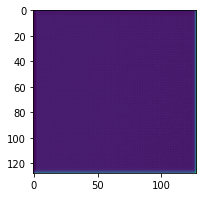

0.0001805
100


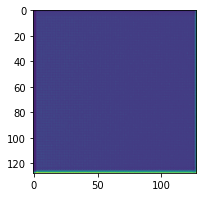

0.00017147499999999998
200


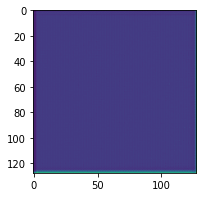

0.00016290125
300


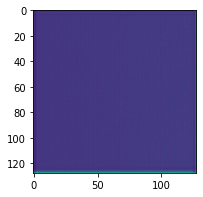

0.00015475618749999996
400


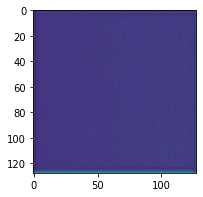

0.00014701837812499996
500


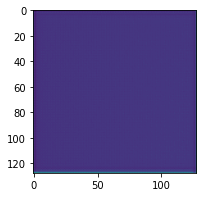

0.00013966745921874994
600


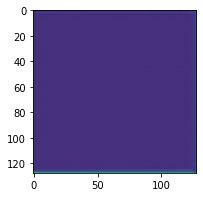

0.00013268408625781246
700


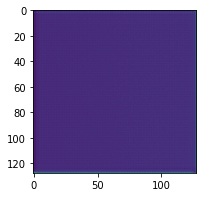

0.0001260498819449218
800


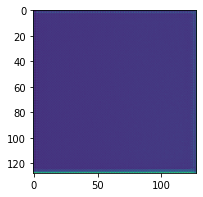

0.00011974738784767575
900


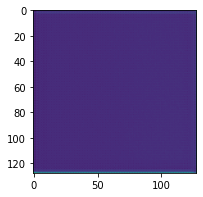

0.00011376001845529194
1000


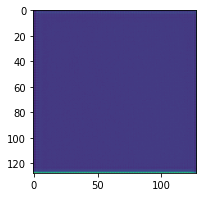

0.00010807201753252734
1100


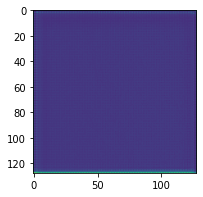

0.00010266841665590097
1200


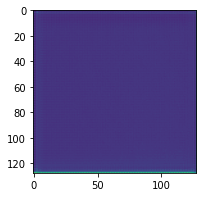

9.75349958231059e-05
1300


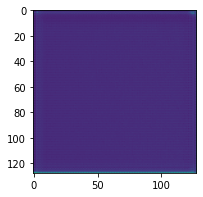

9.265824603195061e-05
1400


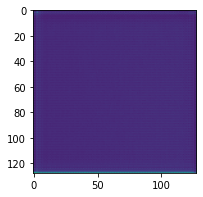

8.802533373035307e-05
1500


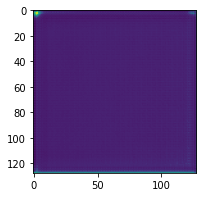

8.362406704383542e-05
1600


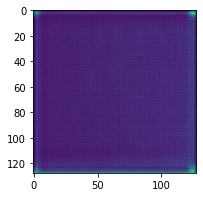

7.944286369164364e-05
1700


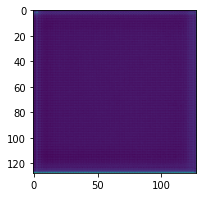

7.547072050706145e-05
1800


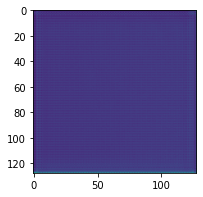

7.169718448170838e-05
1900


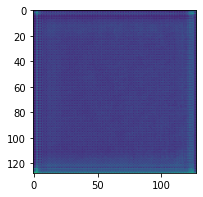

6.811232525762296e-05
2000


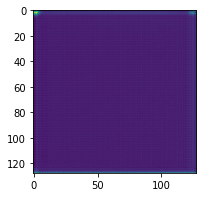

6.470670899474181e-05
2100


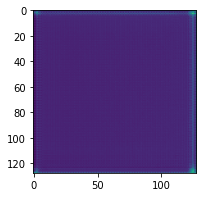

6.147137354500472e-05
2200


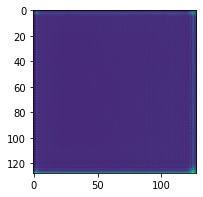

5.839780486775448e-05
2300


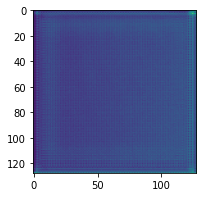

5.5477914624366753e-05
2400


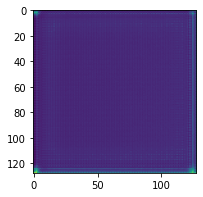

5.270401889314841e-05
2500


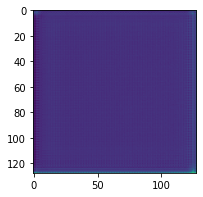

5.0068817948490985e-05
2600


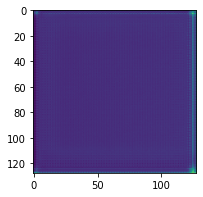

4.756537705106643e-05
2700


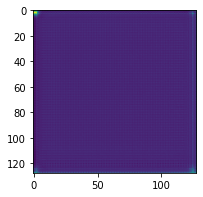

4.518710819851311e-05
2800


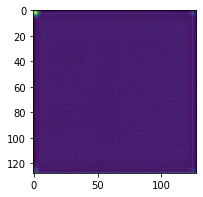

4.292775278858746e-05
2900


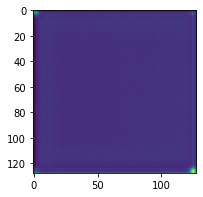

4.078136514915808e-05
3000


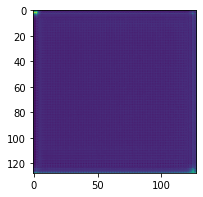

3.874229689170017e-05
3100


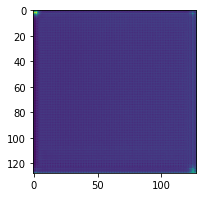

KeyboardInterrupt: 

In [18]:
for i in range(0,4000):
    idx=np.random.choice(train_data.shape[0], replace=False, size=[40])
    cur_train=torch.from_numpy(train_data[idx,:,:,:,:]+0*np.random.uniform(-0.3, 0.3, 1)).float().cuda()
    cur_truth=torch.from_numpy(train_truth[idx,:,:,:,:]).float().cuda()
    
    results = model(cur_train)
    loss = criterion(results, cur_truth)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (i%100==0):
        with torch.no_grad():
            scheduler.step()
            for param_group in optimizer.param_groups:
                print(param_group['lr'])
            #valid = model(torch.from_numpy(validation_data).float().cuda()).cpu().numpy()
            valid = np.concatenate([model(torch.from_numpy(validation_data[(i*40):(i*40+40)]).float().cuda()).cpu().numpy() 
                   for i in range(0,int(np.ceil(validation_data.shape[0]/40)))])
            print(i)
            plt.figure(figsize=[3,3])
            plt.imshow(valid[0,0,0,:,:])
            plt.show()
            
            outputs=np.zeros([tmp.shape[0], 2, tmp.shape[1], tmp.shape[2]])
            outputs[:,0,:,:]=de_window(validation_data[:,0,:,:,:], window_size, tmp.shape)
            outputs[:,1,:,:]=de_window(valid[:,0,:,:,:], window_size, tmp.shape)
            tifffile.imsave(data+'PT_Model_'+str(i).zfill(4)+'.tif', outputs.astype('float32'), imagej=True)
            torch.save(model.state_dict(), data+'PT_weights_'+str(i).zfill(4)+'.pth')
            

Load old weights

# Process a file

In [13]:
model = UNet()
model.cuda()

model.load_state_dict(torch.load(data+'PT_weights_3000.pth'))

<All keys matched successfully>

In [14]:
#raws = tifffile.imread(data+'raws.tif')
#labs = tifffile.imread(data+'labs.tif')

[mean, std] = np.load(data+'MeanStd.npy')

In [15]:
def process_file(fname, model, channel):
    rescaler = rescale.copy()
    rescaler.insert(0,1.0)
    
    img = tifffile.imread(fname)
    img = transform.rescale(img, rescale)
    #img = img[:,channel,:,:]
    
    to_process = make_windows(img, window_size)
    to_process = np.reshape(to_process, [to_process.shape[0], 1, 8, 128, 128])
    to_process=(to_process-mean)/(std*1.0)+0.2
    
    with torch.no_grad():
        result = np.concatenate([model(torch.from_numpy(to_process[(i*40):(i*40+40)]).float().cuda()).cpu().numpy() 
                           for i in range(0,int(np.ceil(to_process.shape[0]/40)))])
    del to_process
    outputs=np.zeros([int(img.shape[0]/rescale[0]), 2, int(img.shape[1]/rescale[1]), int(img.shape[2]/rescale[2])])
    outputs[:,0,:,:]=transform.rescale(img, 1/np.array(rescale))
    outputs[:,1,:,:]=transform.rescale(de_window(result[:,0,:,:,:], window_size, img.shape), 1/np.array(rescale))
    tifffile.imsave(fname[0:-4]+'_UNET'+str(channel)+'.tif', outputs.astype('float32'), imagej=True)

In [17]:
for f in glob.glob(data+'Data/*.tif'):
    print(f)
    process_file(f, model, 0)
    #process_file(f, model, 1)

/n/core/micro/cry/rg2128/smc/DeepLearn3D/Data/Cells_ZStack-6.tif
/n/core/micro/cry/rg2128/smc/DeepLearn3D/Data/789094-1-TH.tif


/scratch/smc/miniconda3/envs/pytorch/lib/python3.7/site-packages/tifffile/tifffile.py:2650: UserWarning: TiffWriter: truncating ImageJ file
  'TiffWriter: truncating ImageJ file', UserWarning


/n/core/micro/cry/rg2128/smc/DeepLearn3D/Data/790233-1-TH.tif
/n/core/micro/cry/rg2128/smc/DeepLearn3D/Data/790233-2-TH.tif
/n/core/micro/cry/rg2128/smc/DeepLearn3D/Data/790232-3-TH.tif
/n/core/micro/cry/rg2128/smc/DeepLearn3D/Data/Cells_ZStack-2.tif
/n/core/micro/cry/rg2128/smc/DeepLearn3D/Data/789094-6-TH.tif
/n/core/micro/cry/rg2128/smc/DeepLearn3D/Data/789094-2-TH.tif
/n/core/micro/cry/rg2128/smc/DeepLearn3D/Data/790232-1-TH.tif
/n/core/micro/cry/rg2128/smc/DeepLearn3D/Data/Cells_ZStack-8.tif
/n/core/micro/cry/rg2128/smc/DeepLearn3D/Data/789094-3-TH.tif
/n/core/micro/cry/rg2128/smc/DeepLearn3D/Data/790233-4-TH.tif
/n/core/micro/cry/rg2128/smc/DeepLearn3D/Data/789094-5-TH.tif
/n/core/micro/cry/rg2128/smc/DeepLearn3D/Data/Cells_ZStack-3.tif
/n/core/micro/cry/rg2128/smc/DeepLearn3D/Data/790233-3-TH.tif
/n/core/micro/cry/rg2128/smc/DeepLearn3D/Data/789094-4-TH.tif
/n/core/micro/cry/rg2128/smc/DeepLearn3D/Data/790232-4-TH.tif
/n/core/micro/cry/rg2128/smc/DeepLearn3D/Data/Cells_ZStack-7.